# *Libraries*


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # Import for custom tick formatting
import seaborn as sns

# *Import Datasets*

In [2]:
train_df = pd.read_csv('DATA/preprocessed_train.csv', low_memory=False)
valid_df = pd.read_csv('DATA/preprocessed_valid.csv', low_memory=False)
test_df = pd.read_csv('DATA/preprocessed_test.csv', low_memory=False)

In [3]:
train_df.shape, valid_df.shape, test_df.shape

((20745, 11), (5187, 11), (6484, 11))

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20745 entries, 0 to 20744
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_income               20745 non-null  float64
 1   person_home_ownership       20745 non-null  int64  
 2   person_emp_length           20745 non-null  float64
 3   loan_intent                 20745 non-null  int64  
 4   loan_grade                  20745 non-null  int64  
 5   loan_amnt                   20745 non-null  int64  
 6   loan_status                 20745 non-null  int64  
 7   loan_percent_income         20745 non-null  float64
 8   cb_person_default_on_file   20745 non-null  int64  
 9   cb_person_cred_hist_length  20745 non-null  int64  
 10  ID                          20745 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1.7 MB


# *Data Preparation for Modeling*

In [5]:
modeling_variables = ['person_income', 'person_home_ownership', 'person_emp_length',
       'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length']

target_variable = 'loan_status'

In [6]:
# Take necessary columns

# Train
X_train = train_df[modeling_variables]
y_train = train_df[target_variable]

# Validation
X_valid = valid_df[modeling_variables]
y_valid = valid_df[target_variable]

# Test
X_test = test_df[modeling_variables]
y_test = test_df[target_variable]

# *Modeling*

In [7]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", early_stopping_rounds=10, importance_type='total_gain')

In [8]:
xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid), (X_train, y_train)], verbose=True)

[0]	validation_0-auc:0.90791	validation_1-auc:0.90658
[1]	validation_0-auc:0.90887	validation_1-auc:0.90849
[2]	validation_0-auc:0.92113	validation_1-auc:0.91925
[3]	validation_0-auc:0.92181	validation_1-auc:0.91981
[4]	validation_0-auc:0.92300	validation_1-auc:0.92092
[5]	validation_0-auc:0.92586	validation_1-auc:0.92203
[6]	validation_0-auc:0.92843	validation_1-auc:0.92514
[7]	validation_0-auc:0.92989	validation_1-auc:0.92747
[8]	validation_0-auc:0.93241	validation_1-auc:0.93073
[9]	validation_0-auc:0.93277	validation_1-auc:0.93198
[10]	validation_0-auc:0.93514	validation_1-auc:0.93689
[11]	validation_0-auc:0.93533	validation_1-auc:0.93755
[12]	validation_0-auc:0.93570	validation_1-auc:0.93853
[13]	validation_0-auc:0.93683	validation_1-auc:0.93986
[14]	validation_0-auc:0.93719	validation_1-auc:0.94101
[15]	validation_0-auc:0.93706	validation_1-auc:0.94160
[16]	validation_0-auc:0.93681	validation_1-auc:0.94253
[17]	validation_0-auc:0.93769	validation_1-auc:0.94397
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type='total_gain',
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
monotone_constraints= [-1, 1, -1, 1, 1, 1, 1, 1, -1] 

In [10]:
print("Train AUC:", roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:, 1]))
print("Validation AUC:", roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1]))
print("Test AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

Train AUC: 0.9873273455806044
Validation AUC: 0.9425120002834015
Test AUC: 0.9403361524156947


In [11]:
# calculate the feature importances
feature_importances = pd.DataFrame(xgb_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)*100

<Axes: xlabel='importance'>

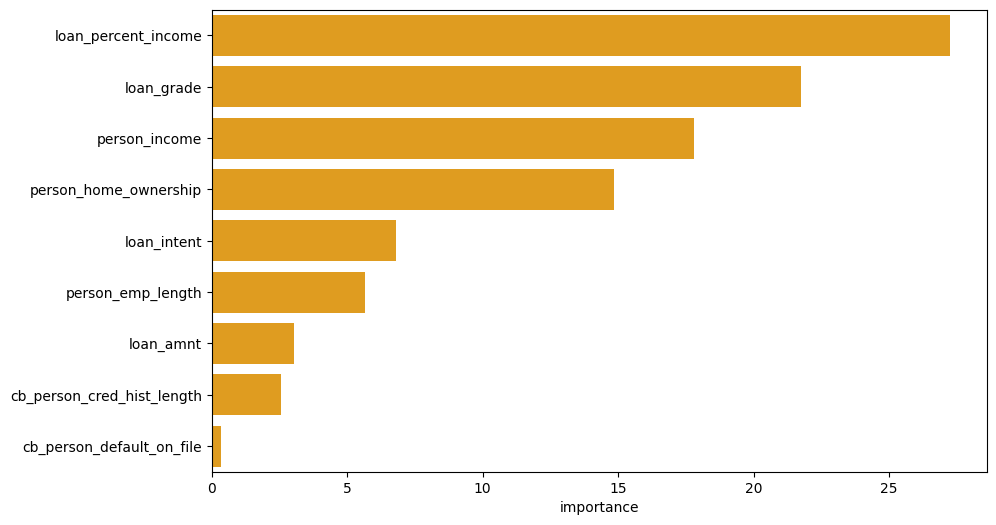

In [12]:
# plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index, color="orange")

In [13]:
monotone_constraints= {'person_income': -1, 'person_home_ownership': 1, 'person_emp_length': -1,
                        'loan_intent': 1, 'loan_grade': 1, 'loan_amnt': 1, 'loan_percent_income': 1,
                        'cb_person_default_on_file': 1, 'cb_person_cred_hist_length': -1}

In [14]:
xgb_model_mc = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", early_stopping_rounds=10, importance_type='total_gain', monotone_constraints=monotone_constraints)

xgb_model_mc.fit(X_train, y_train, eval_set=[(X_valid, y_valid), (X_train, y_train)], verbose=True)

[0]	validation_0-auc:0.88197	validation_1-auc:0.88157
[1]	validation_0-auc:0.90052	validation_1-auc:0.89592
[2]	validation_0-auc:0.90446	validation_1-auc:0.89994
[3]	validation_0-auc:0.91092	validation_1-auc:0.90592
[4]	validation_0-auc:0.91252	validation_1-auc:0.90664
[5]	validation_0-auc:0.91395	validation_1-auc:0.90806
[6]	validation_0-auc:0.91492	validation_1-auc:0.90907
[7]	validation_0-auc:0.91815	validation_1-auc:0.91210
[8]	validation_0-auc:0.92071	validation_1-auc:0.91437
[9]	validation_0-auc:0.92097	validation_1-auc:0.91486
[10]	validation_0-auc:0.92261	validation_1-auc:0.91641
[11]	validation_0-auc:0.92259	validation_1-auc:0.91681
[12]	validation_0-auc:0.92383	validation_1-auc:0.91782
[13]	validation_0-auc:0.92437	validation_1-auc:0.91841
[14]	validation_0-auc:0.92517	validation_1-auc:0.91924
[15]	validation_0-auc:0.92558	validation_1-auc:0.91972
[16]	validation_0-auc:0.92561	validation_1-auc:0.91987
[17]	validation_0-auc:0.92573	validation_1-auc:0.92013
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type='total_gain',
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_...
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan,
              monotone_constraints={'cb_person_cred_hist_length': -1,
                                    'cb_person_default_on_file': 1,
                                    'loan_amnt': 1, 'loan_grade': 1,
                                    'loan_intent': 1, 'loan_percent_income': 1,
                                    'person_emp_length': -1,
                                    'person_home_ownership': 1,
                                    'person_income': -1},
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [15]:
print("Train AUC:", roc_auc_score(y_train, xgb_model_mc.predict_proba(X_train)[:, 1]))
print("Validation AUC:", roc_auc_score(y_valid, xgb_model_mc.predict_proba(X_valid)[:, 1]))
print("Test AUC:", roc_auc_score(y_test, xgb_model_mc.predict_proba(X_test)[:, 1]))

Train AUC: 0.921813375689021
Validation AUC: 0.926238663938927
Test AUC: 0.9229756539638221


### Hyperparameter Tuning

In [16]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',  
    cv=3,               
    verbose=2,
    n_jobs=-1           
)

grid_search.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],  
    verbose=True
)

print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[0]	validation_0-auc:0.79952
[1]	validation_0-auc:0.85397
[2]	validation_0-auc:0.88426
[3]	validation_0-auc:0.87966
[4]	validation_0-auc:0.89080
[5]	validation_0-auc:0.88646
[6]	validation_0-auc:0.88270
[7]	validation_0-auc:0.88169
[8]	validation_0-auc:0.88521
[9]	validation_0-auc:0.88702
[10]	validation_0-auc:0.89051
[11]	validation_0-auc:0.89575
[12]	validation_0-auc:0.89542
[13]	validation_0-auc:0.89461
[14]	validation_0-auc:0.89658
[15]	validation_0-auc:0.89594
[16]	validation_0-auc:0.89601
[17]	validation_0-auc:0.89583
[18]	validation_0-auc:0.89613
[19]	validation_0-auc:0.89656
[20]	validation_0-auc:0.89645
[21]	validation_0-auc:0.89644
[22]	validation_0-auc:0.89670
[23]	validation_0-auc:0.89654
[24]	validation_0-auc:0.89641
[25]	validation_0-auc:0.89626
[26]	validation_0-auc:0.89598
[27]	validation_0-auc:0.89634
[28]	validation_0-auc:0.89643
[29]	validation_0-auc:0.89758
[30]	validation_0-auc:0.89732
[31]	validation_